In [1]:
#Config
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns

from scipy.interpolate import griddata

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

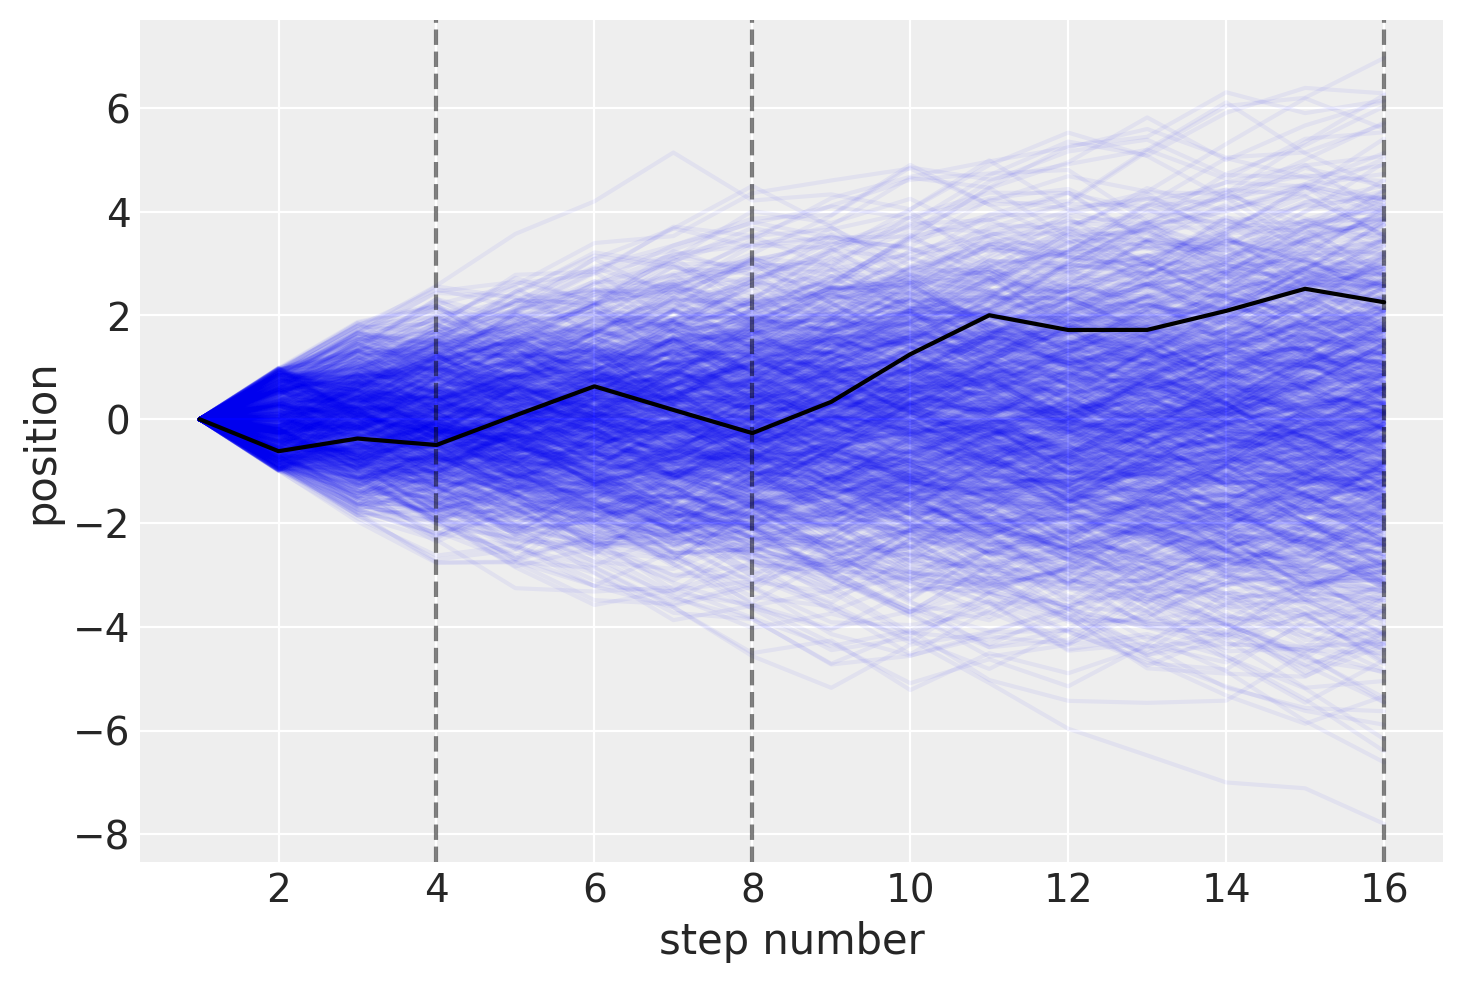

In [6]:
# Simulation of field trip
np.random.seed(1234)
steps = 16
repetitions = 1000
x = np.zeros([steps, repetitions])

for i in range(x.shape[1]):
    x[1:, i] = np.cumsum(np.random.uniform(-1, 1, steps - 1))

plt.plot(range(1, 17), x[:, :], c="b", alpha=0.05)
plt.plot(range(1, 17), x[:, 0], c="k")
plt.axvline(4, linestyle="--", c="k", alpha=0.5)
plt.axvline(8, linestyle="--", c="k", alpha=0.5)
plt.axvline(16, linestyle="--", c="k", alpha=0.5)
plt.xlabel("step number")
plt.ylabel("position")
plt.show()


/Users/sunnygaur/dataScience/statistical_rethinking/stats_rethink/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/sunnygaur/dataScience/statistical_rethinking/stats_rethink/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/sunnygaur/dataScience/statistical_rethinking/stats_rethink/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated fun

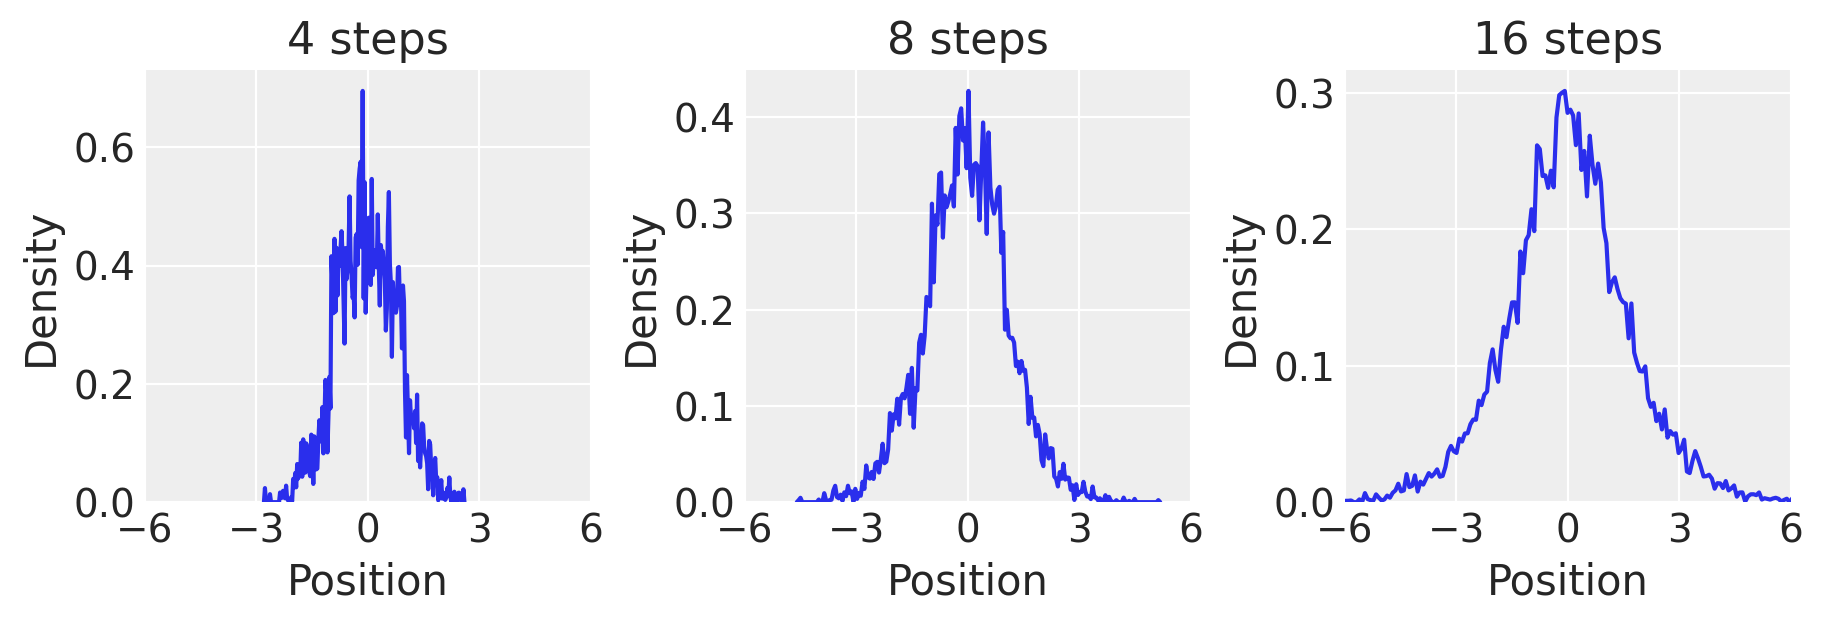

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3), sharex=True)
sns.distplot(x[1:4, :], kde_kws={"bw_method": 0.01}, ax=ax[0], hist=False)
sns.distplot(x[1:8, :], kde_kws={"bw_method": 0.01}, ax=ax[1], hist=False)
sns.distplot(x[1:, :], kde_kws={"bw_method": 0.01}, ax=ax[2], hist=False)

ax[0].set_title("4 steps")
ax[1].set_title("8 steps")
ax[2].set_title("16 steps")

for i in range(3):
    ax[i].set_ylabel("Density")
    ax[i].set_xlabel("Position")
    ax[i].set_xlim(-6, 6)
    ax[i].set_xticks([-6, -3, 0, 3, 6])

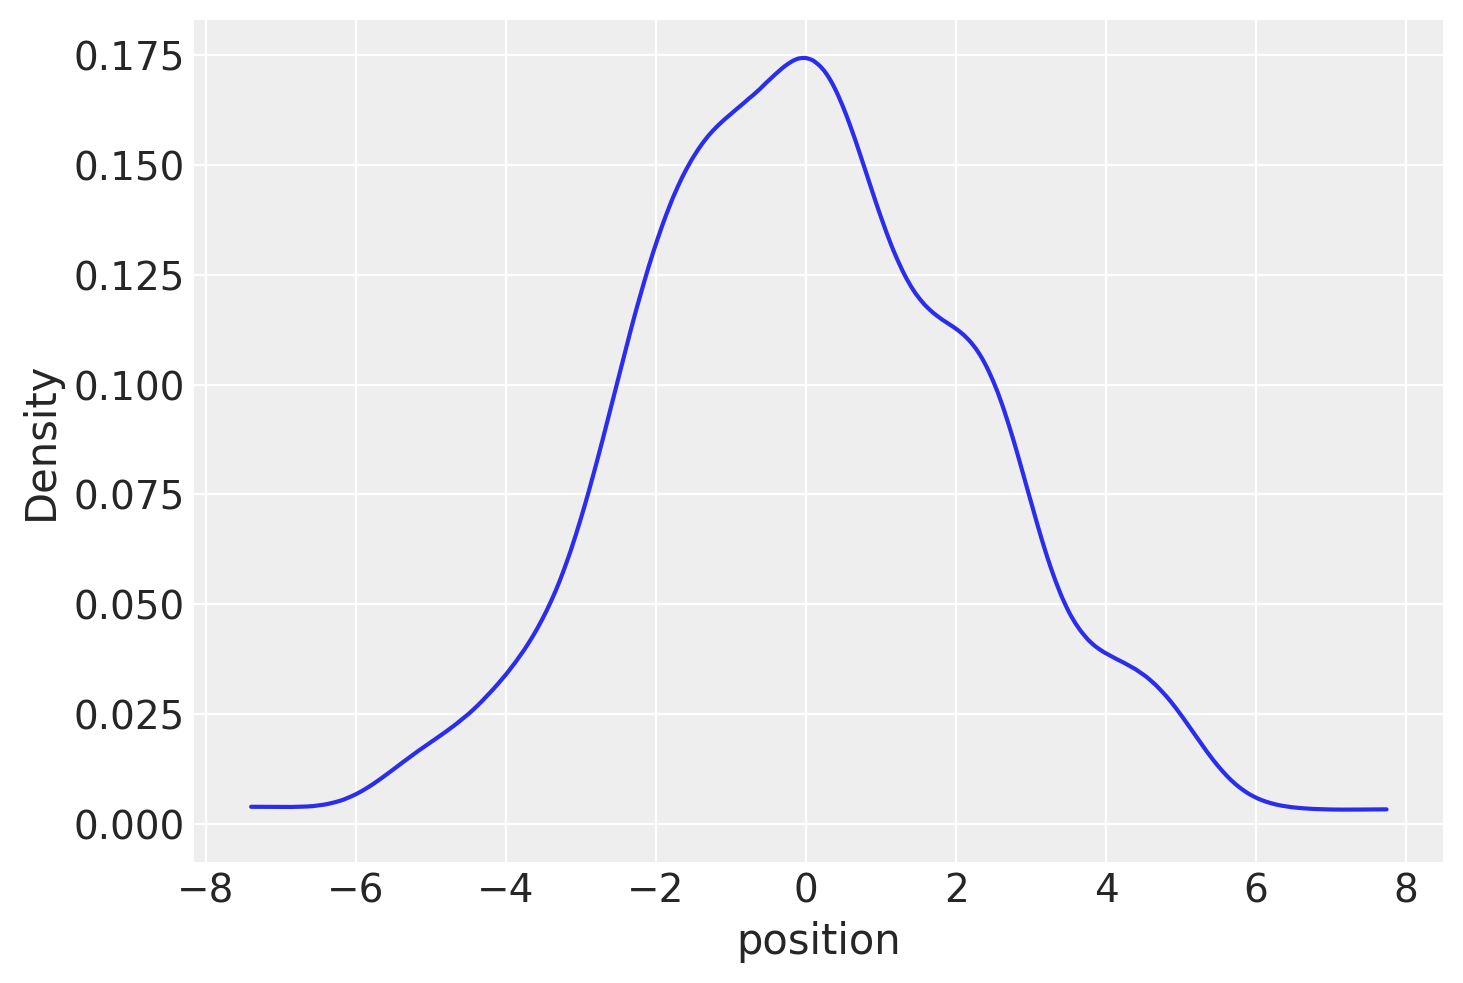

In [11]:
pos = np.random.uniform(-1, 1, size=(16, 1000)).sum(0)
az.plot_kde(pos)
plt.xlabel("position")
plt.ylabel("Density");


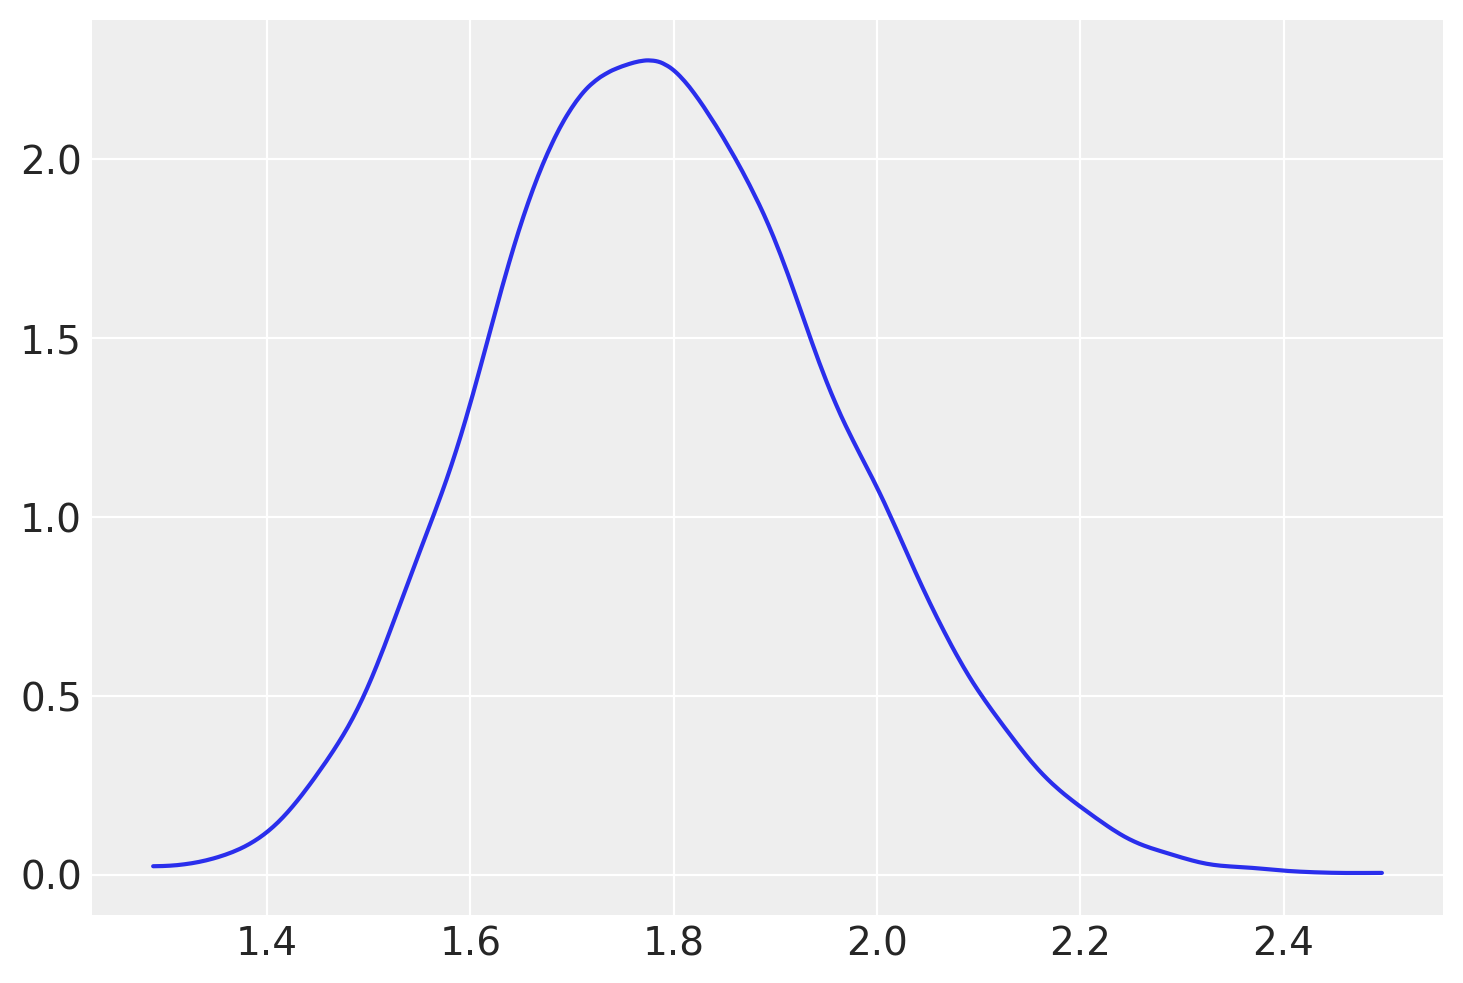

In [12]:
pos = np.random.uniform(1, 1.1, size=(12, 10000)).prod(0)
az.plot_kde(pos);

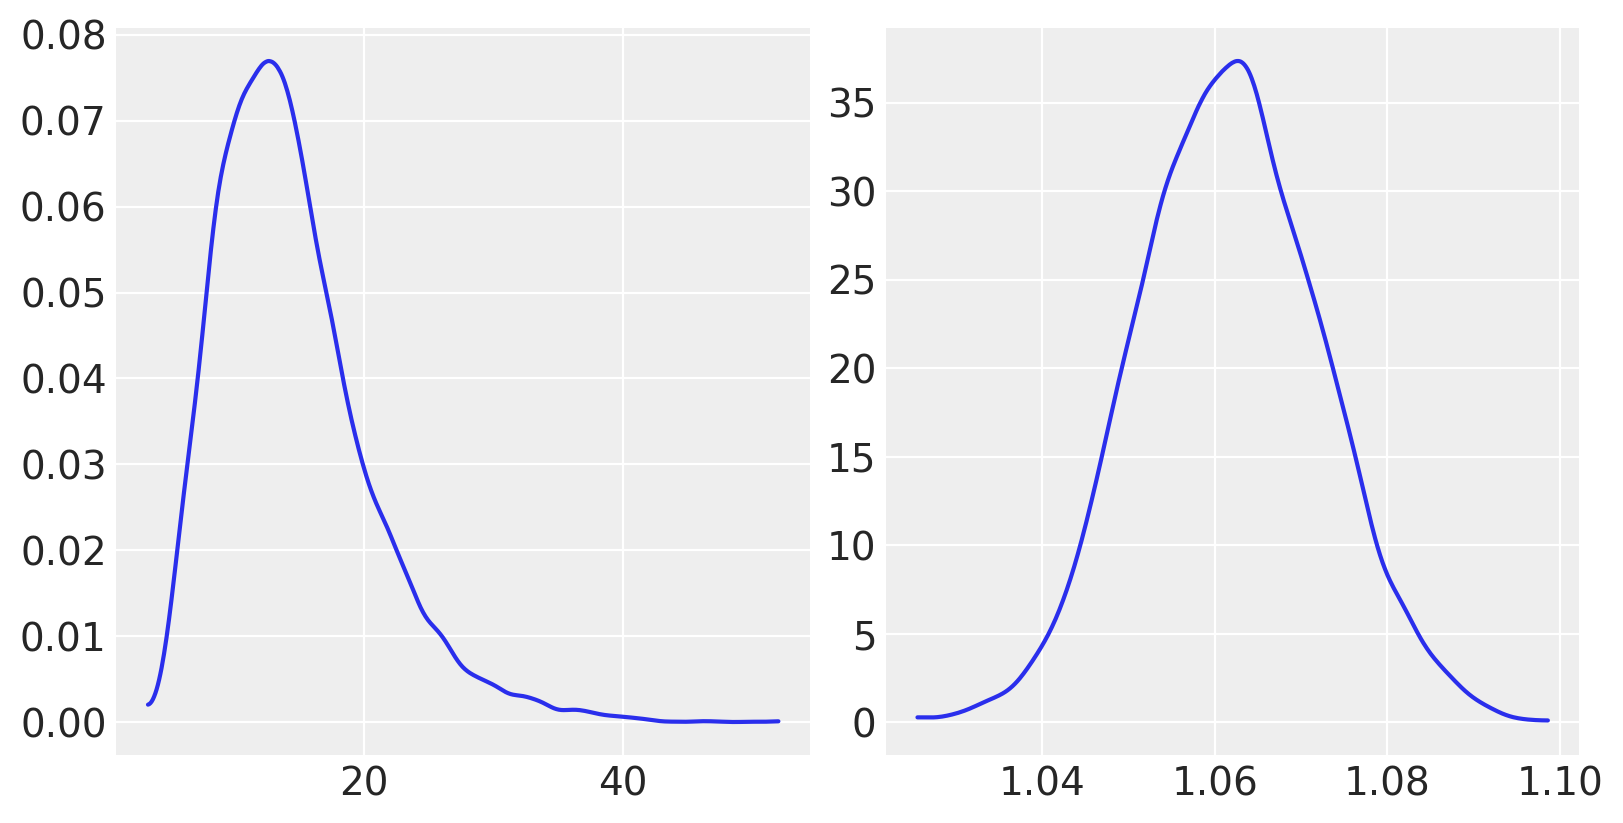

In [13]:
big = np.random.uniform(1, 1.5, size=(12, 10000)).prod(0)
small = np.random.uniform(1, 1.01, size=(12, 10000)).prod(0)
_, ax = plt.subplots(1, 2, figsize=(8, 4))
az.plot_kde(big, ax=ax[0])
az.plot_kde(small, ax=ax[1]);


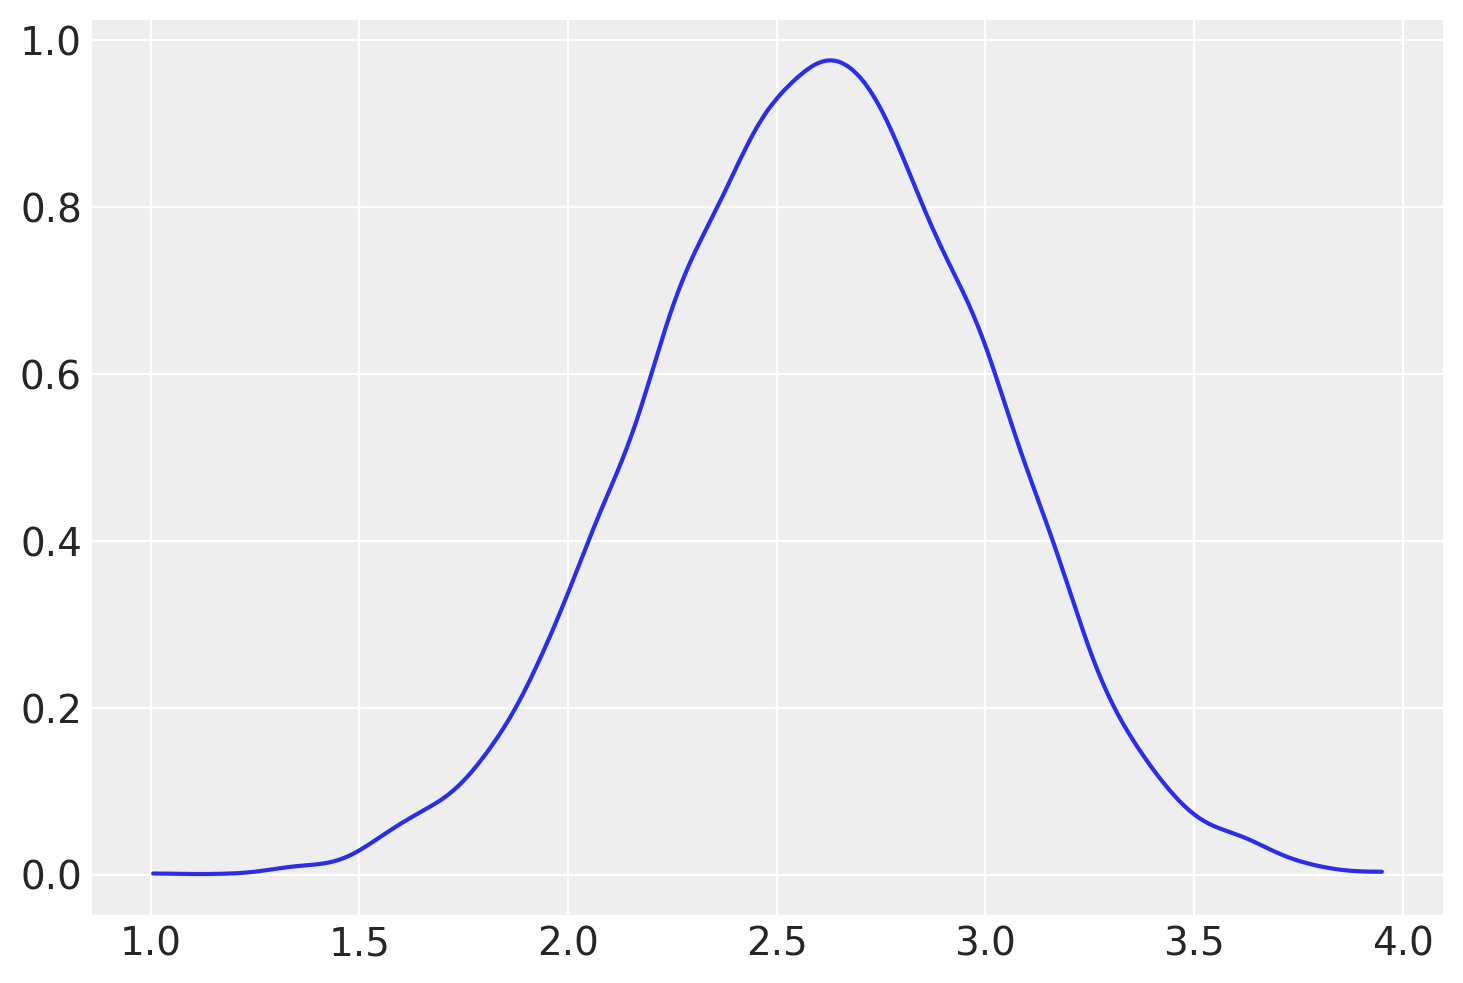

In [14]:
log_big = np.log(np.random.uniform(1, 1.5, size=(12, 10000)).prod(0))
az.plot_kde(log_big);


### Basic Language for Describing Models
$
\begin{aligned}
y_{i} \sim && \text{Normal}(\mu_{i},\sigma) \\
\mu_{i} = && \beta x_{i} \\
\beta \sim && \text{Normal}(0,10) \\
\sigma \sim && \text{Exponential }(1) \\
x_{i} \sim && \text{Normal}(0,1) \\
\end{aligned}
$

In [16]:
#4.6
w = 6
n = 9
p_grid = np.linspace(0, 1, 100)
posterior = stats.binom.pmf(k=w, n=n, p=p_grid) * stats.uniform.pdf(p_grid, 0, 1)
posterior = posterior / sum(posterior)

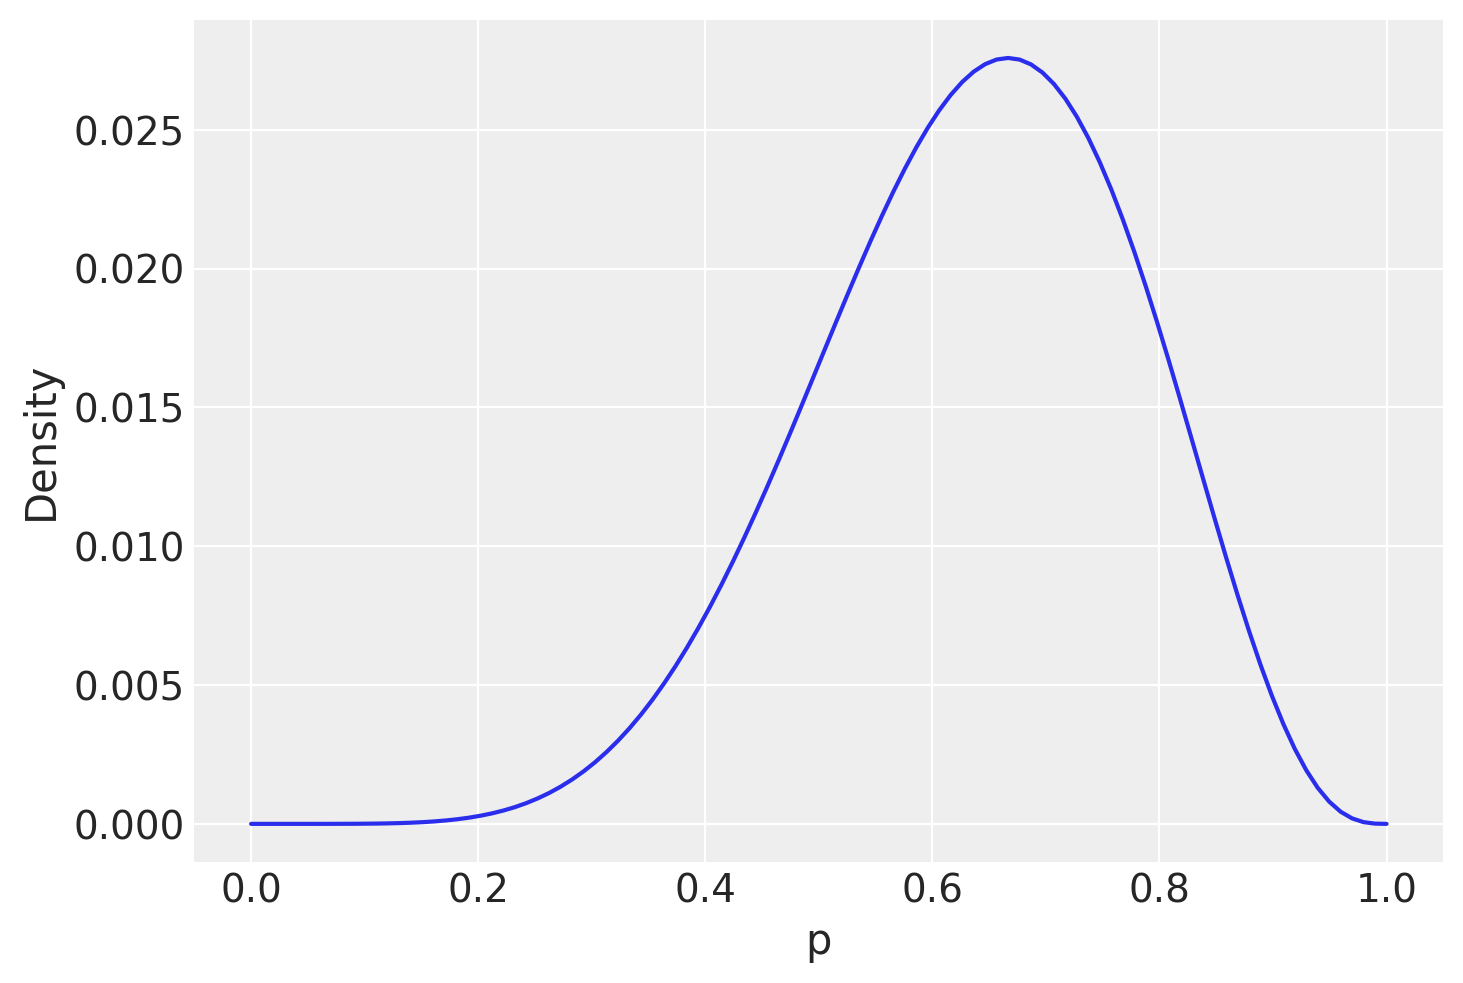

In [19]:
plt.plot(p_grid, posterior)
plt.xlabel("p")
plt.ylabel("Density");


### Gaussian Model of Height

In [20]:
d = pd.read_csv("Data/Howell1.csv", sep=";", header=0)
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [24]:
d.describe()

,height,weight,age,male
count,544.000000,544.000000,544.000000,544.000000
mean,138.263596,35.610618,29.344393,0.472426
std,27.602448,14.719178,20.746888,0.499699
min,53.975000,4.252425,0.000000,0.000000
25%,125.095000,22.007717,12.000000,0.000000
50%,148.590000,40.057844,27.000000,0.000000
75%,157.480000,47.209005,43.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


In [25]:
d.height

0      151.765
1      139.700
2      136.525
3      156.845
4      145.415
        ...   
539    145.415
540    162.560
541    156.210
542     71.120
543    158.750
Name: height, Length: 544, dtype: float64

In [43]:
d2 = d[d.age >= 18]

In [49]:
len(d2)

352

To complete the model, we're going to need some priors 


$
\begin{aligned}
h_{i} \sim && \text{Normal}(\mu_{i},\sigma) ; \text{[likelihood]} \\
\mu_{i} \sim && \text{Normal}(178, 20) ; \text{[mu prior]} \\
\sigma \sim && \text{Uniform}(0, 50) ; \text{[sigma prior]} \\
\end{aligned}
$

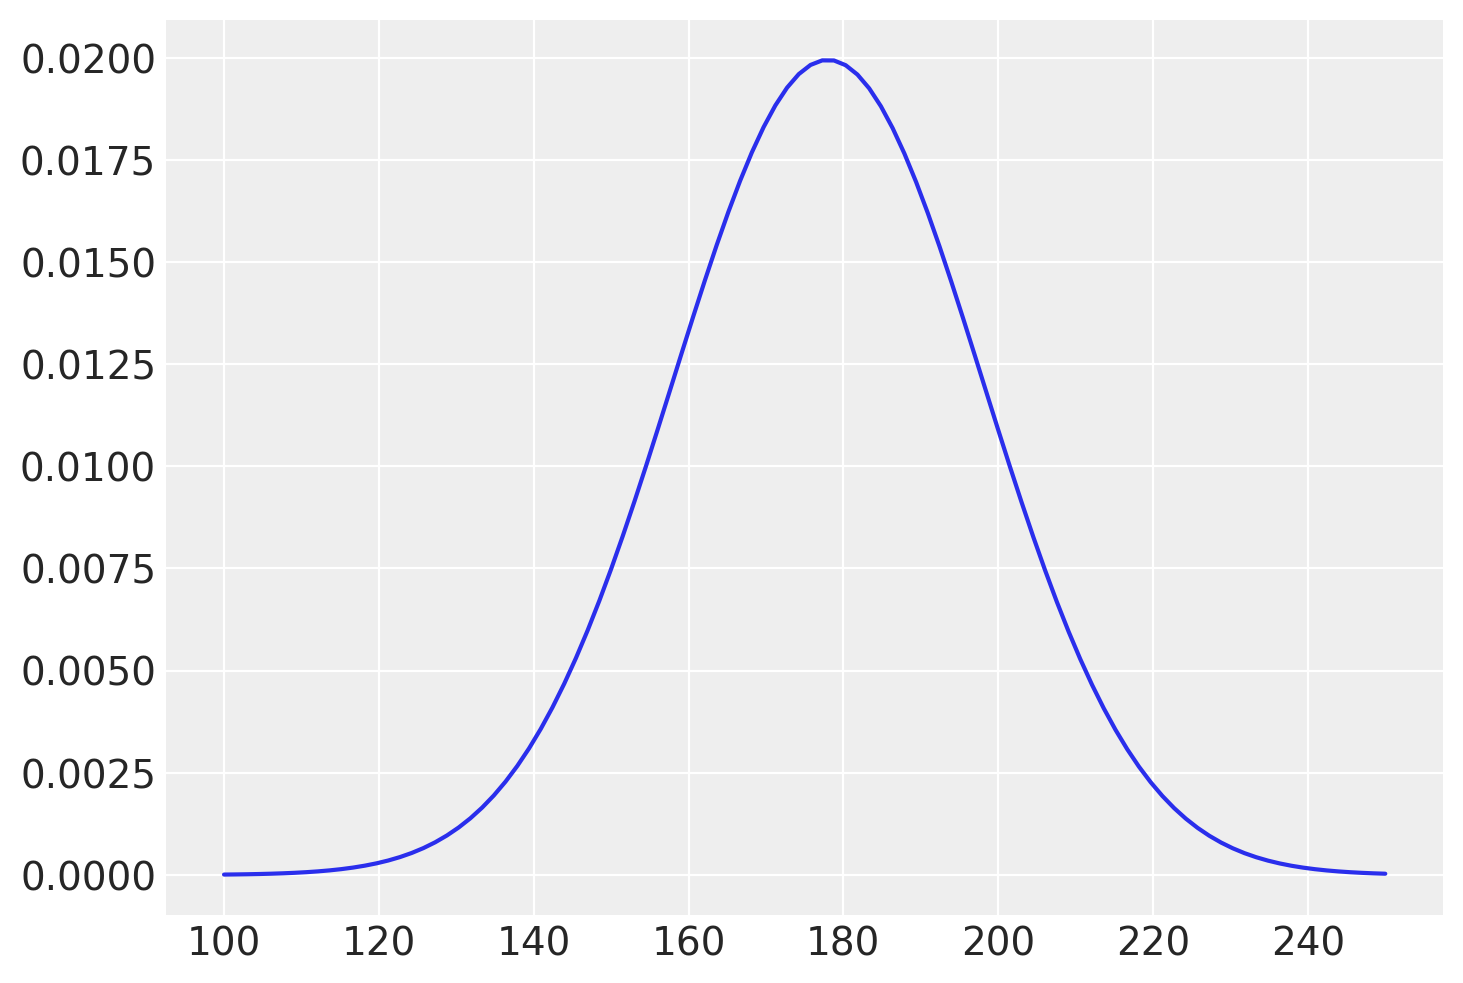

In [51]:
# Plot your priors 
x = np.linspace(100, 250, 100)
mu = 178
sigma = 20
curve = stats.norm.pdf(x, mu, sigma)
plt.plot(x, curve);

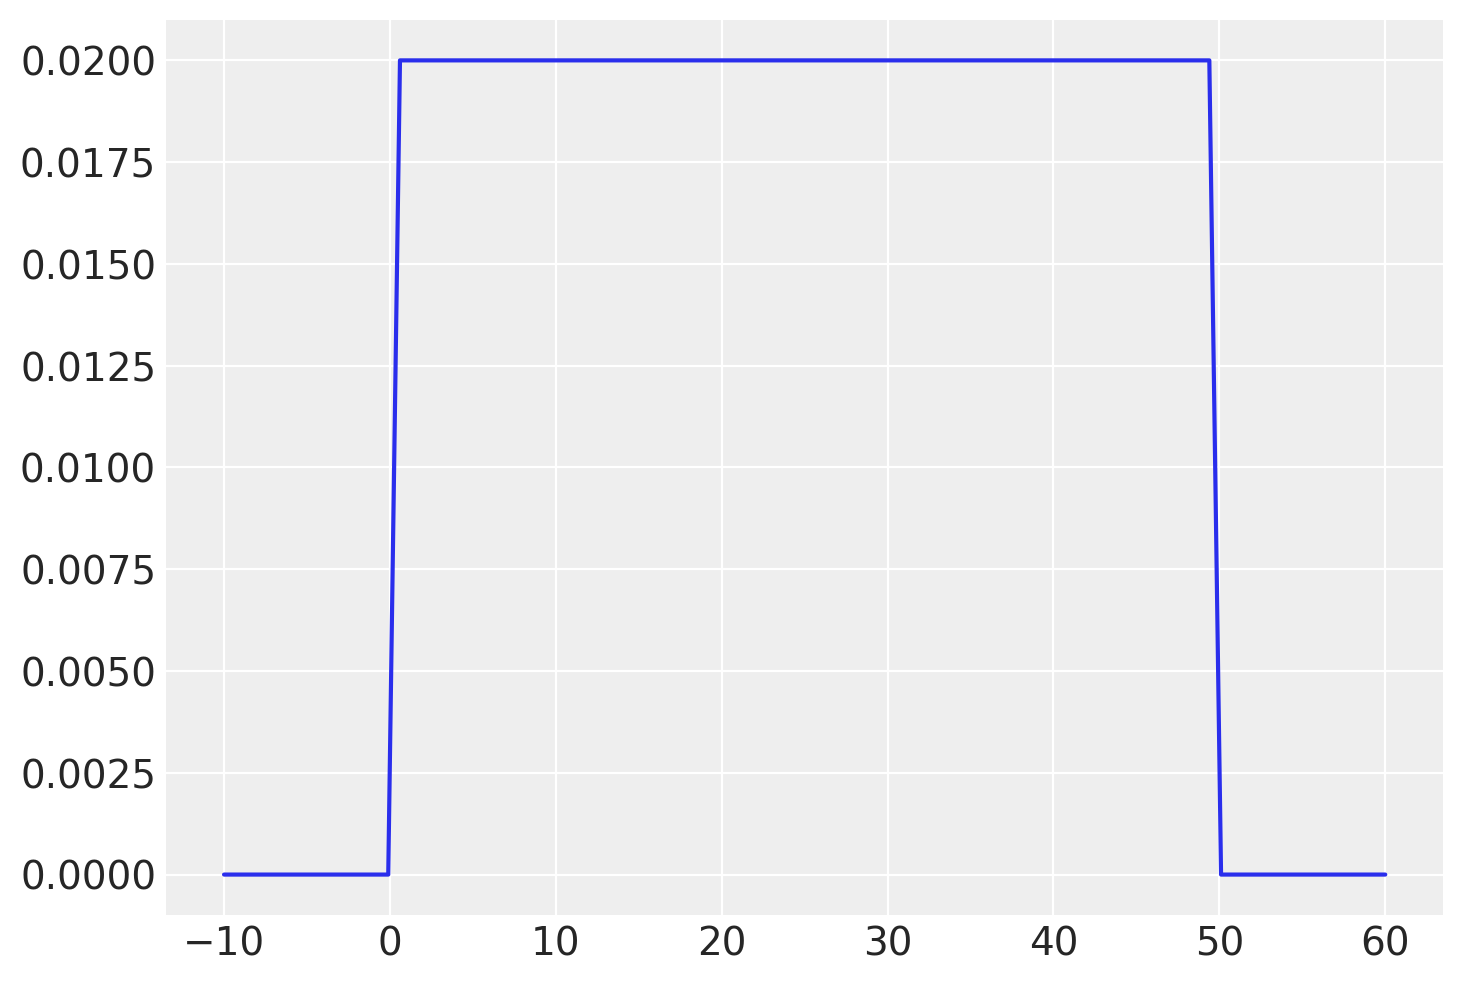

In [65]:
x = np.linspace(-10, 60, 100)
curve = stats.uniform.pdf(x, 0, 50)
plt.plot(x, curve)